In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np

setup_notebook()

In [2]:
from datasets.stocks_data_wrapper import StocksDataWrapper
from helpers.data_helper import *
from helpers.plots_helper import *

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


### Prepare data

In [4]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'PEP'
price_column = 'Close'
project_label='LinearNN2Classes'

predict_n = 5

In [5]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", thresh_diff=0.003,
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,0.000000,1972-07-19,0.007099,0.006974,0.007014,0.006990,0.001856,0.007721,0.000000,0.529348,...,0.006642,0.006217,0.006444,0.664795,0.458663,0.495574,0.431372,lower,0.007052,higher
1,0.000081,1972-07-20,0.006943,0.006787,0.006920,0.006896,0.001830,0.005264,0.000000,0.471709,...,0.006639,0.006214,0.006431,0.664403,0.458663,0.495734,0.440561,lower,0.007396,higher
2,0.000162,1972-07-21,0.006881,0.006803,0.006888,0.006927,0.001839,0.005966,0.000307,0.493056,...,0.006655,0.006209,0.006424,0.664590,0.458497,0.496372,0.479195,stay,0.007271,lower
3,0.000243,1972-07-24,0.006912,0.006818,0.006951,0.006943,0.001843,0.008890,0.000000,0.504037,...,0.006672,0.006202,0.006420,0.664686,0.458299,0.496292,0.474321,stay,0.007255,stay
4,0.000324,1972-07-25,0.006943,0.006865,0.006982,0.006974,0.001851,0.010177,0.000000,0.526556,...,0.006685,0.006201,0.006420,0.664835,0.458190,0.496372,0.479154,stay,0.007365,higher


In [6]:
data_wrapper['Next'].value_counts()

higher    4932
lower     4713
stay      2695
Name: Next, dtype: int64

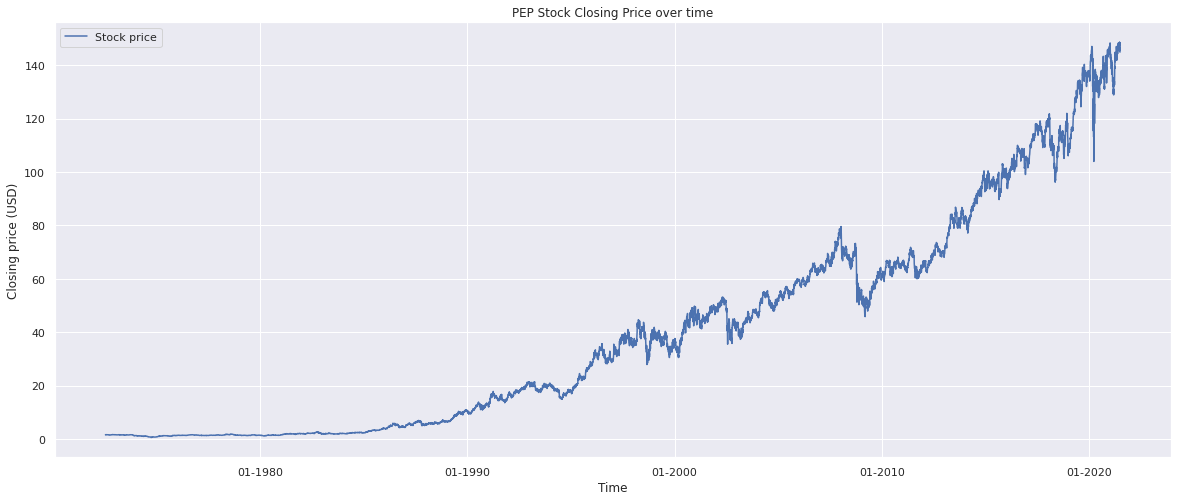

In [7]:
prices = data_wrapper.get_unscaled_data()['Close']
plot_prices(price_series=prices, date_series=data_wrapper['Date'], quotation_name=quotation)
plt.show()

In [8]:
#ax = plot_normalized_histogram(data_wrapper.get_unscaled_data()['PercentageDiff'])

In [9]:
#ax = plot_normalized_histogram(data_wrapper.get_unscaled_data()['Difference'])

In [10]:
print(data_wrapper.feature_names)

['LowLen', 'RSI(14)', 'GAP', 'RSI_diff', 'Volume_diff', 'MACD', 'MACD_diff', 'MACD_signal', 'BodyLen', 'BG_L_Band', 'BG_H_Band', 'BG_L_Band_Indicator', 'BG_H_Band_Indicator', 'ROC', 'StochOsc', 'SMA(10)', 'SMA(20)', 'EMA(14)', 'EMA_Diff', 'SMA(20) - SMA(10)', 'Difference', 'PercentageDiff', 'Tendency', 'NextPrice', 'Next']


In [11]:
from torch.utils.data import Dataset
from datasets.torch_datasets import StocksDataset


y_column = 'Next'
data_columns = ['Volume', 'Close', 'LowLen', 'Difference', 'SMA(20) - SMA(10)', 'BG_H_Band_Indicator', 'MACD']
#data_columns = data_wrapper.feature_names

X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2, 
                                                             y_column=y_column, negative_labels=False,
                                                             features_list=data_columns)

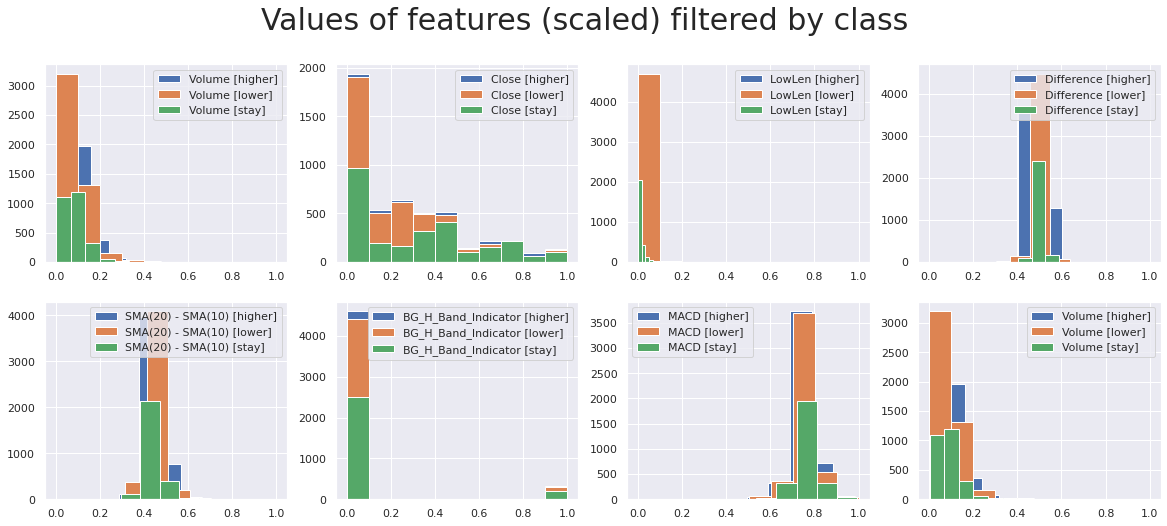

In [12]:
N_COLS = 4
plot_feature_names = data_columns.copy()

if 'Next' in plot_feature_names:
    plot_feature_names.remove('Next')
if 'Volume' in data_wrapper.df.columns.values:
    plot_feature_names.append('Volume')

plot_filtered_class_features(data_wrapper.df, n_cols=N_COLS, feature_names=plot_feature_names, class_column='Next')

plt.show()

In [13]:
from torch.utils.data import DataLoader
train_dataset = StocksDataset(X_train,y_train)
test_dataset = StocksDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


print(f"Train size : {len(train_dataset)}, test_size : {len(test_dataset)}")

Train size : 9872, test_size : 2468


In [14]:
print(np.unique(y_train))

[0 1 2]


### Model

In [15]:
from models.pytorch_linear_model import LinearModel
from trainers.pytorch_classification_trainer import PytorchClassificationTrainer

import torch.nn as nn

n_classes = len(np.unique(y_train))

config = dict(
    lr=1e-5,
    loss=nn.CrossEntropyLoss,
    n_epochs=100,
    optimizer=torch.optim.Adam,
)
model = LinearModel(config, input_dim=X_train.shape[1], output_dim=n_classes, device=device)
print(model)


trainer = PytorchClassificationTrainer(model, device=device, use_wandb=True, project_label=project_label)
trainer.train(dataloader=train_dataloader)

LinearModel(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): LeakyReLU(negative_slope=0.1)
    (10): Linear(in_features=16, out_features=3, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/LinearNN2Classes/runs/37gk91sw


In [16]:
trainer.evaluate(test_dataloader)

{'accuracy': 0.3512965964343598, 'f1_score': 0.284784194599569}

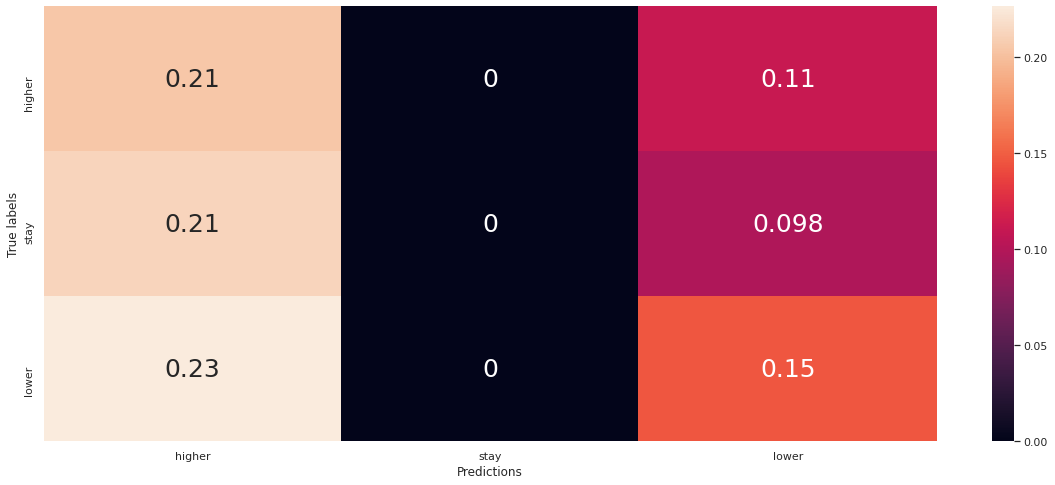

In [17]:
predictions, labels = trainer.predict(test_dataloader)
predictions = predictions.argmax(1)

ax = plot_heatmap(labels, predictions, class_labels=['higher', 'stay', 'lower'], normalize='all')